# Negative breaks XGBoost model - local run with loop

### Peter R.
#### 2024-02-24

Given that DRAC was down on Feb. 22 and 23, 2024, I had to run DRAC XGBoost models locally. Here I run XGB models in a loop in an attempt to be more efficient.




In [1]:
# 2024-03-04
# Peter R.
# XGBoost script
# Positive breaks, n_estimators (number of trees)=1000 and with optimal parameter from DRAC model_bp1 & early stopping

#Here I am using a loop to run several models at a time

import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# for feature importance plots
from matplotlib import pyplot
import matplotlib.pyplot as plt

#for dependency plots
from sklearn.inspection import PartialDependenceDisplay

#start = time.time()

# Get the current working directory
cwd = os.getcwd()

#print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")
# Win directory
os.chdir(r'C:\Users\Peter R\github\forc_trends\models\xgboost')


print("XGB version:", xgb.__version__)
print("negative breaks")


# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_negative_v3.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()

df2 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)

XGB version: 1.7.6
negative breaks


In [2]:
#print(df2[['canlad_year']].describe())#
#print(df2[['hansen_year']].describe())#
print(df2.describe())

                 pix          year      brk     brkdate25       brkdate  \
count   11969.000000  11969.000000  11969.0  11969.000000  11969.000000   
mean   225229.956722   2012.628039      0.0   2012.109550   2013.087316   
std    160929.313809      3.992787      0.0      3.932185      4.010560   
min       554.000000   2003.000000      0.0   2003.000000   2003.957000   
25%     75823.000000   2010.000000      0.0   2009.609000   2010.391000   
50%    194166.000000   2013.000000      0.0   2012.348000   2013.391000   
75%    387465.000000   2016.000000      0.0   2014.652000   2016.391000   
max    493308.000000   2021.000000      0.0   2021.870000   2021.957000   

          brkdate95     magnitude  no_brk    fire_year    harv_year  ...  \
count  11969.000000  11969.000000     0.0   139.000000  1187.000000  ...   
mean    2013.377788   -830.508460     NaN  2017.568345  2012.196293  ...   
std        3.960877    359.003319     NaN     2.163767     4.409600  ...   
min     2004.000000 

MSE: 79602.37
RMSE: 282.14
R-sq: 0.353
R-sq-adj: 0.350


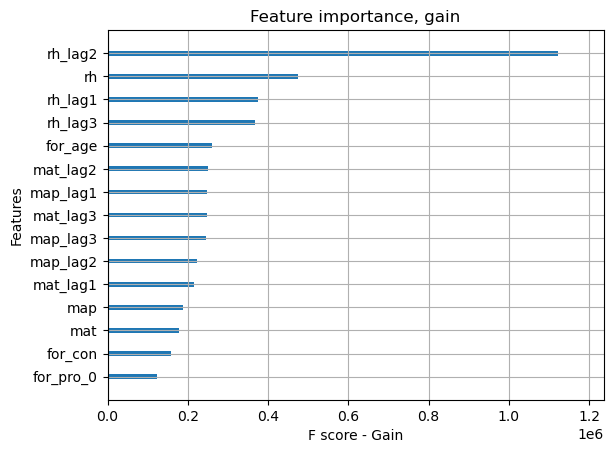

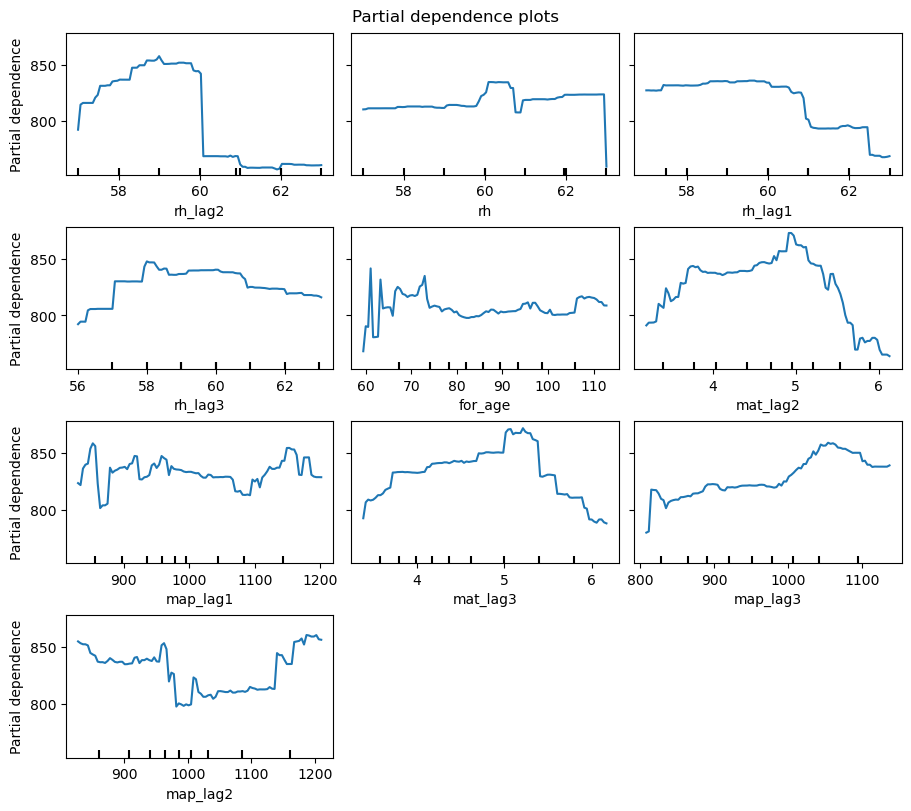

MSE: 81946.96
RMSE: 286.26
R-sq: 0.334
R-sq-adj: 0.332


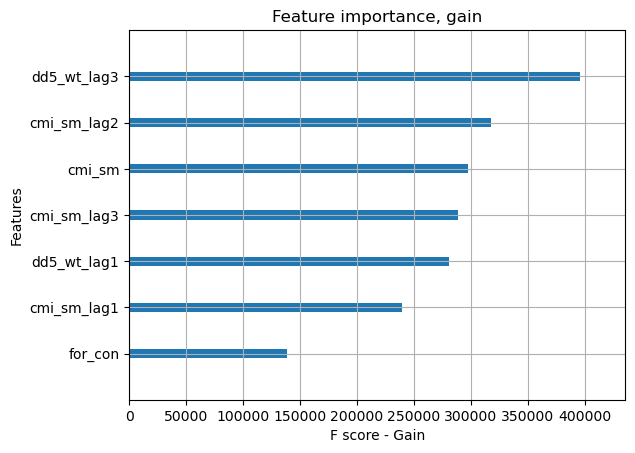

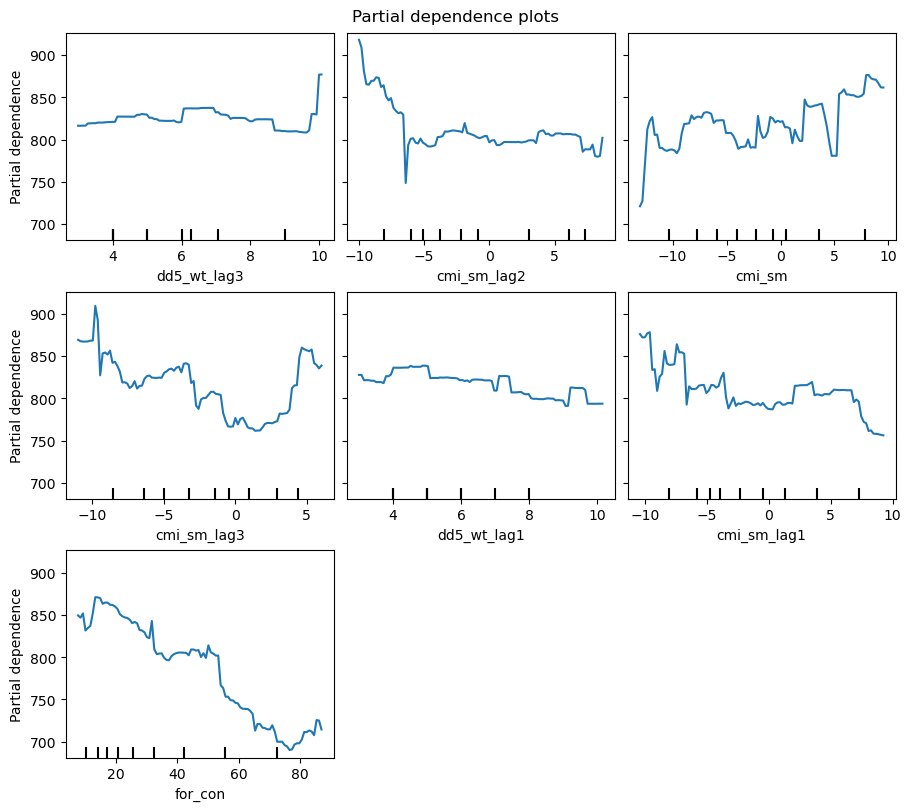

MSE: 81922.19
RMSE: 286.22
R-sq: 0.334
R-sq-adj: 0.332


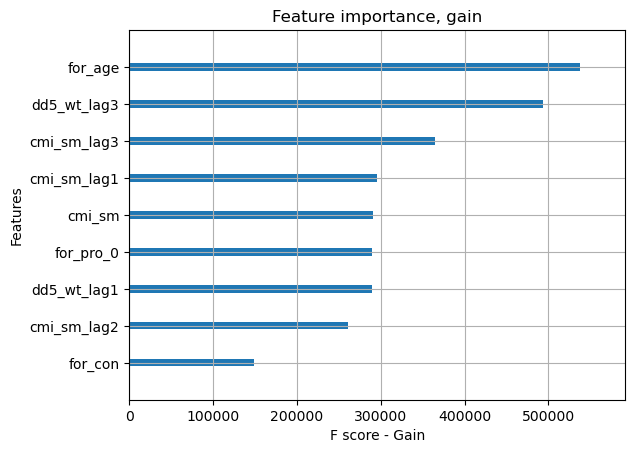

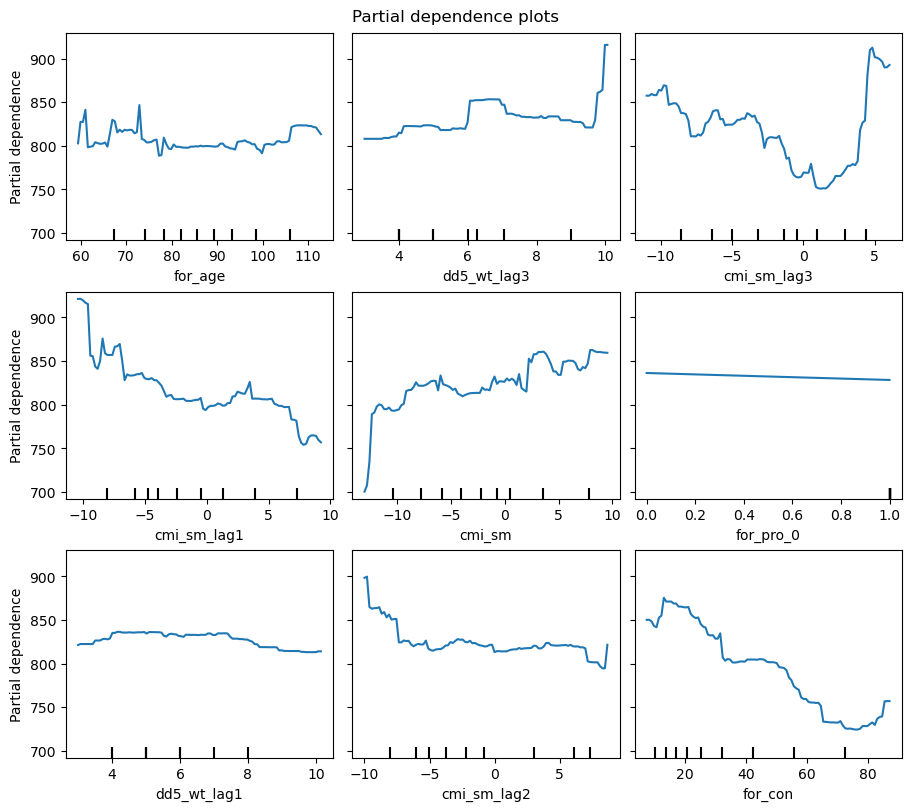

In [45]:
# loop version

cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']


list_of_vars = [ [cols1], [cols2], [cols3]]
for list in list_of_vars:
    for x in list:
        #print(x)
        X1 = df2[x]
        #print(X1.describe())
        y1 = df2.iloc[:,6].abs()
        seed = 7 # random seed to help with replication
        testsize1 = 0.33 # percent of records to test after training
        x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
        model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
           # EVALUATION (with test)
        eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
            #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
        model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
            # make predictions for test data
        y_pred = model_bp2.predict(x1_test)
        predictions = [round(value) for value in y_pred]
            # retrieve performance metrics
        results = model_bp2.evals_result()
        mse = mean_squared_error(y1_test, y_pred)
            #r2 = explained_variance_score(y1_test, ypred)
        r2 = r2_score(y1_test, y_pred)
            # adjusted R-squared
        adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

        print("MSE: %.2f" % mse)

        print("RMSE: %.2f" % (mse**(1/2.0)))

        print("R-sq: %.3f" % r2)

        print("R-sq-adj: %.3f" % adj_r2)
        
        # Feature importance plot
        xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )
            
        pyplot.savefig(r'.\figs\version3\neg_gain_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        #pyplot.show()
        # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
        features_names1 = pd.DataFrame()
        features_names1['columns'] = X1.columns
        features_names1['importances'] = model_bp2.feature_importances_
        features_names1.sort_values(by='importances',ascending=False,inplace=True)
        features_names2 = features_names1['columns'].tolist()[0:10]

        _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

        display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

        _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

        pyplot.savefig(r'.\figs\version3\neg_partial_dep_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        
        pyplot.show()

**Table 1**: Model comparison for negative breaks. Standard data set with all records (including NAs for for_age and for_con).


| Model   | MSE| RMSE| R-sq | R-sq-adj |
| -------- | ------- |-------- | ------- |------- |
|1.First variable set (15)| 79602.37|282.14| 0.353| 0.350
|2.VIF variable set (7)| 81946.96|286.26|  0.334| 0.332
|3.VIFplus variable set (9)|  81922.19|286.22| 0.334|0.332




In [3]:
#Describe the data
X1 = df2[x]
print(X1.shape)

NameError: name 'x' is not defined

In [47]:
#print(len(cols1))

In [48]:
# Count NAs per columns to check that step above worked #mat 607 before, now 0
#X1.isna().sum()

In [49]:
#X1.describe()

### Models without records that have disturbance matches

When dealing with positive forest EVI breaks, I can't remove records matched to Hansen et al.'s disturbance data as there are no such matched records. This makes sense as positive breaks should not be matched to disturbances.

In [50]:
# How many records are matched to Hansen et al.'s data?
print(df2[['hansen_year']].describe()) # 5315

       hansen_year
count  5315.000000
mean   2012.886548
std       4.364003
min    2004.000000
25%    2010.000000
50%    2013.000000
75%    2017.000000
max    2021.000000


There are matches when using CanLaD

In [51]:
print(df2[['canlad_year']].describe()) # 2483
#print(df2[['harv_year']].describe()) # 1187
#print(df2[['fire_year']].describe()) # 139

       canlad_year
count  2483.000000
mean   2009.973822
std       2.918397
min    2004.000000
25%    2008.000000
50%    2010.000000
75%    2012.000000
max    2015.000000


In [52]:
# This produces an empty df as there are no records
#df3 = df2.drop(df2[df2.hansen_year > 0].index)
#X3.tail
#X3.shape
#df3.describe()
df2.drop(df2[df2.hansen_year > 0].index, inplace=True)
df2.shape

(6654, 158)

In [53]:
#df2.drop(df2[df2.hansen_year > 0].index).describe()

MSE: 87831.66
RMSE: 296.36
R-sq: 0.379
R-sq-adj: 0.374


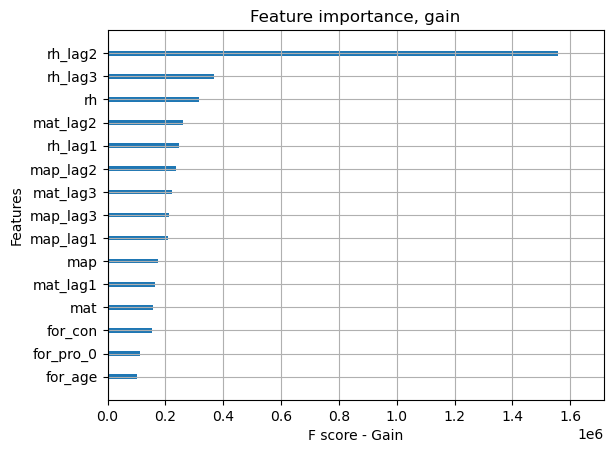

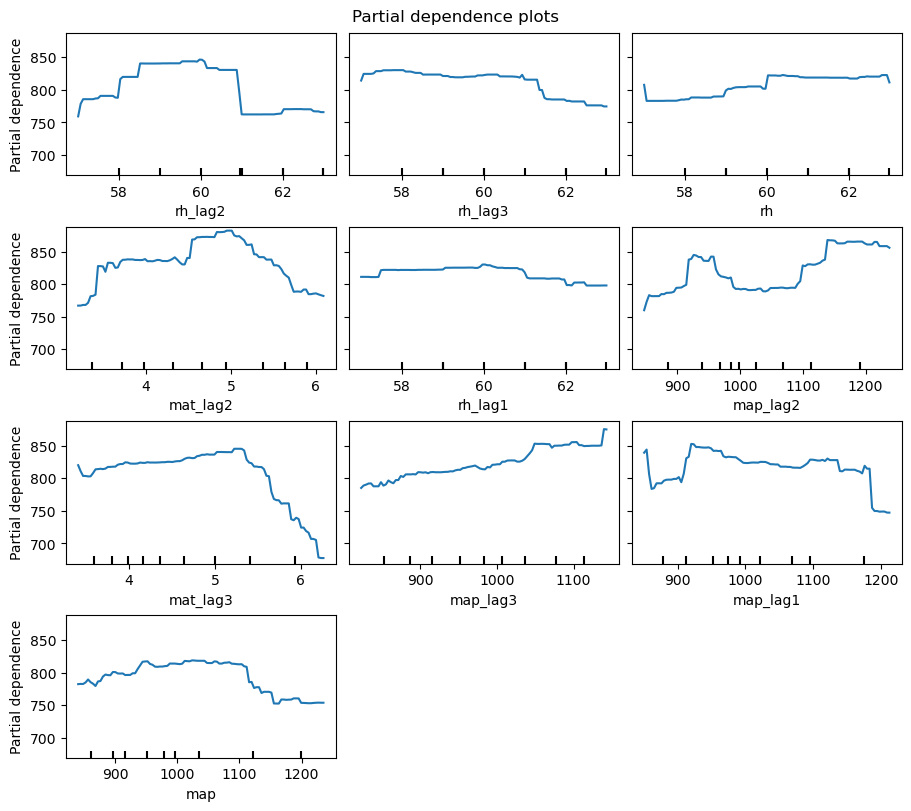

MSE: 85505.89
RMSE: 292.41
R-sq: 0.395
R-sq-adj: 0.393


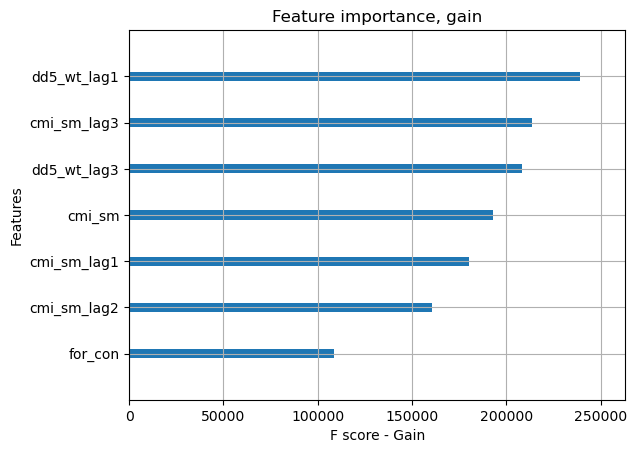

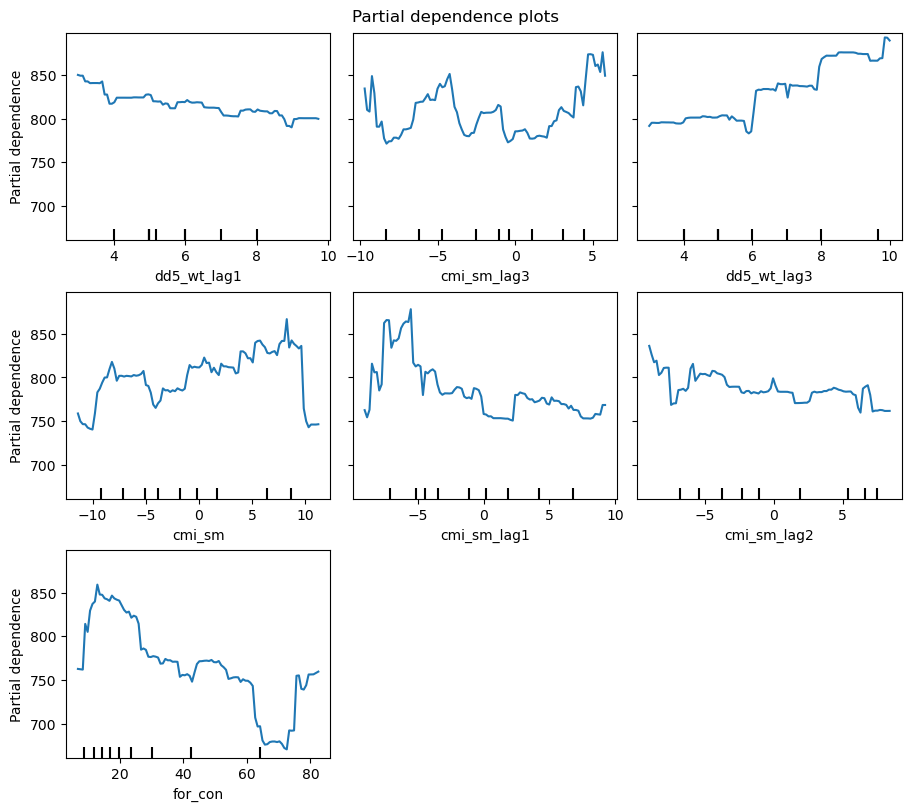

MSE: 85019.08
RMSE: 291.58
R-sq: 0.398
R-sq-adj: 0.396


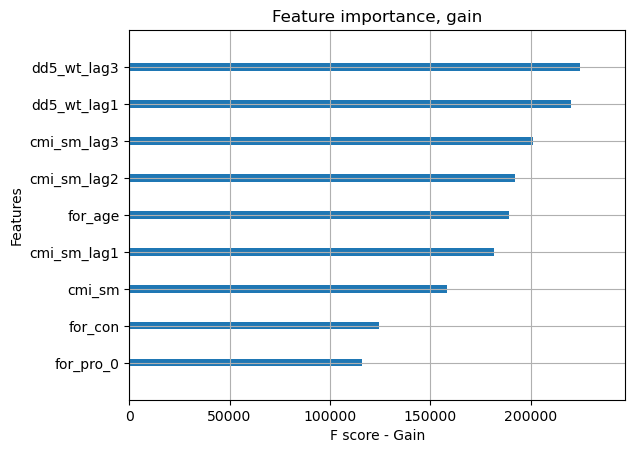

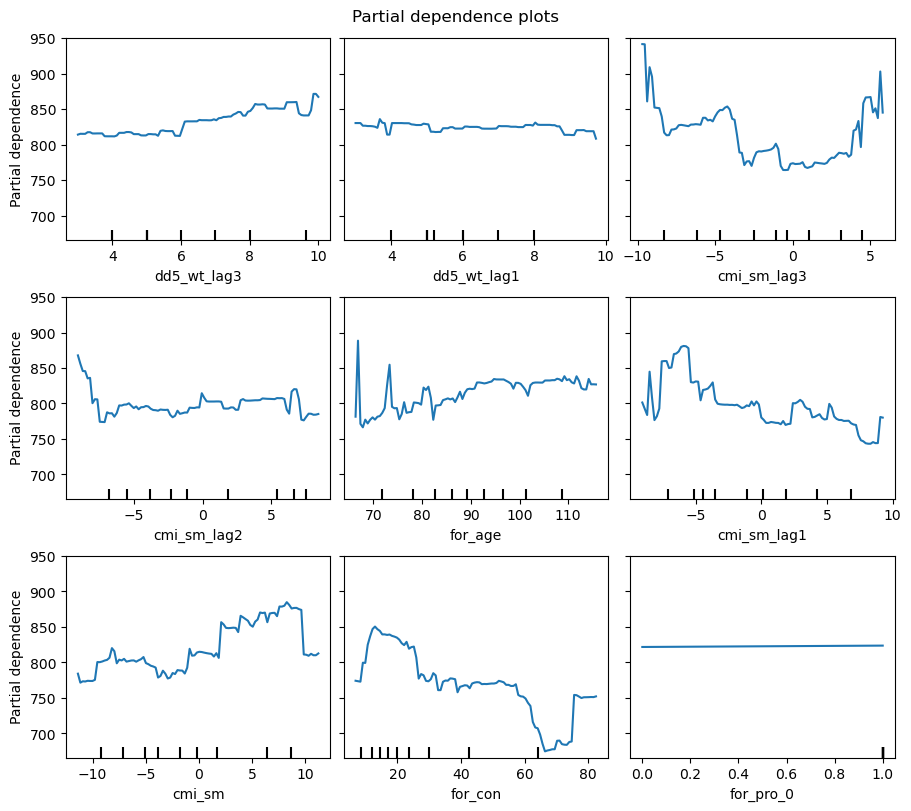

In [54]:
# loop version

cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']


list_of_vars = [ [cols1], [cols2], [cols3]]
for list in list_of_vars:
    for x in list:
        #print(x)
        X1 = df2[x]
        #print(X1.describe())
        y1 = df2.iloc[:,6].abs()
        seed = 7 # random seed to help with replication
        testsize1 = 0.33 # percent of records to test after training
        x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
        model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
           # EVALUATION (with test)
        eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
            #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
        model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
            # make predictions for test data
        y_pred = model_bp2.predict(x1_test)
        predictions = [round(value) for value in y_pred]
            # retrieve performance metrics
        results = model_bp2.evals_result()
        mse = mean_squared_error(y1_test, y_pred)
            #r2 = explained_variance_score(y1_test, ypred)
        r2 = r2_score(y1_test, y_pred)
            # adjusted R-squared
        adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

        print("MSE: %.2f" % mse)

        print("RMSE: %.2f" % (mse**(1/2.0)))

        print("R-sq: %.3f" % r2)

        print("R-sq-adj: %.3f" % adj_r2)
        
        # Feature importance plot
        xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )
            
        pyplot.savefig(r'.\figs\version3\neg_gain_m{y}_v2.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        #pyplot.show()
        # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
        features_names1 = pd.DataFrame()
        features_names1['columns'] = X1.columns
        features_names1['importances'] = model_bp2.feature_importances_
        features_names1.sort_values(by='importances',ascending=False,inplace=True)
        features_names2 = features_names1['columns'].tolist()[0:10]

        _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

        display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

        _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

        pyplot.savefig(r'.\figs\version3\neg_partial_dep_m{y}_v2.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        
        pyplot.show()

Partial dependence plots

**Table 2**: Model comparison for negative breaks. Subset of data records was used, excluding records that had a match with disturbance data. (Some NAs for for_age and for_con.)


| Model   | MSE| RMSE| R-sq | R-sq-adj |
| -------- | ------- |-------- | ------- |------- |
| 1. First variable set (14)| 87831.66|296.36|  0.379| 0.374
| 2. VIF variable set (7)| 85505.89|292.41| 0.395| 0.393
| 3. VIFplus variable set (9)| 85019.08|291.58| 0.398| 0.396